# IMPORTS

In [1]:
import re
import polars as pl
import seaborn as sns

from pathlib import Path

# CONFIGS

In [2]:
pl.Config.set_fmt_str_lengths(900)
pl.Config.set_tbl_width_chars(900)

polars.config.Config

In [3]:
sns.set_theme(rc={
    "savefig.bbox": "tight",
    "savefig.pad_inches": 0.0,
    "figure.figsize": (20, 8),
})

# VARIABLES

In [4]:
FIGURES_PATH = Path("figures")
RESULTS_PATH = Path("results")
STATS_GLOB = "*_stats.csv"
FAILURES_GLOB = "*_failures.csv"
EXCEPTIONS_GLOB = "*_exceptions.csv"
HISTORY_GLOB = "*_stats_history.csv"

# DATASETS

In [5]:
def load_dataset(root: Path, glob: str, pattern: re.Pattern = r"^(?P<approach>.+?)_(?P<model>.+?)_.+\.csv$") -> pl.DataFrame:
    dataframes = []
    for file in root.glob(glob):
        match = re.search(pattern, file.name)
        if match:
            dataframe = pl.read_csv(file, try_parse_dates=True)
            dataframe = dataframe.with_columns([
                pl.lit(match.group("model")).alias("model"),
                pl.lit(match.group("approach")).alias("approach"),
                pl.lit(f"{match.group('approach')} - {match.group('model')}").alias("test"),
            ])
            dataframes.append(dataframe)
        else:
            print(f"Skipping file {file.name} as it does not match the expected pattern: {pattern}.")
    return pl.concat(dataframes, how="vertical")

In [6]:
stats = load_dataset(RESULTS_PATH, STATS_GLOB)
stats

Type,Name,Request Count,Failure Count,Median Response Time,Average Response Time,Min Response Time,Max Response Time,Average Content Size,Requests/s,Failures/s,50%,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%,model,approach,test
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,str,str
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",1213,311,28000.0,29287.715304,2225.500275,60491.58465,831.317395,4.049889,1.038347,28000,46000,60000,60000,60000,60000,60000,60000,60000,60000,60000,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it"""
null,"""Aggregated""",1213,311,28000.0,29287.715304,2225.500275,60491.58465,831.317395,4.049889,1.038347,28000,46000,60000,60000,60000,60000,60000,60000,60000,60000,60000,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash-lite-preview-06-17:generateContent""",156894,153610,210.0,275.777045,102.164956,3885.674632,446.343436,524.603762,513.623108,210,240,260,280,370,670,1000,1800,3400,3700,3900,"""gemini-2.5-flash-lite-preview-06-17-thinking""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-lite-preview-06-17-thinking"""
null,"""Aggregated""",156894,153610,210.0,275.777045,102.164956,3885.674632,446.343436,524.603762,513.623108,210,240,260,280,370,670,1000,1800,3400,3700,3900,"""gemini-2.5-flash-lite-preview-06-17-thinking""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-lite-preview-06-17-thinking"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent""",139640,137688,200.0,311.450341,104.102484,10104.550656,378.308973,465.570523,459.062405,200,230,250,260,320,610,1000,3400,8400,9200,10000,"""gemini-2.5-flash-thinking""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-thinking"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
null,"""Aggregated""",163993,160879,190.0,264.983806,102.714846,4958.318723,479.88008,546.984741,536.598258,190,220,240,260,320,620,1100,2100,3500,4000,5000,"""gemini-2.5-flash-lite-preview-06-17""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-lite-preview-06-17"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent""",112776,110780,190.0,2760.920479,103.059125,3.0859e7,352.599826,3.624184,3.560041,190,220,240,250,340,700,1100,2600,8700,10000,30859000,"""gemini-2.5-flash""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash"""
null,"""Aggregated""",112776,110780,190.0,2760.920479,103.059125,3.0859e7,352.599826,3.624184,3.560041,190,220,240,250,340,700,1100,2600,8700,10000,30859000,"""gemini-2.5-flash""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash"""


In [21]:
stats.filter(pl.col("Type").eq("POST")).select(
    "approach",
    "model",
    "Request Count",
    "Failure Count",
    "Requests/s",
    "Failures/s",
    "Average Response Time",
    "Min Response Time",
    "Max Response Time",
)

approach,model,Request Count,Failure Count,Requests/s,Failures/s,Average Response Time,Min Response Time,Max Response Time
str,str,i64,i64,f64,f64,f64,f64,f64
"""VertexAIEndpoint""","""gemma-3-12b-it""",1213,311,4.049889,1.038347,29287.715304,2225.500275,60491.58465
"""VertexAIMaaS""","""gemini-2.5-flash-lite-preview-06-17-thinking""",156894,153610,524.603762,513.623108,275.777045,102.164956,3885.674632
"""VertexAIMaaS""","""gemini-2.5-flash-thinking""",139640,137688,465.570523,459.062405,311.450341,104.102484,10104.550656
"""VertexAIMaaS""","""gemini-2.5-flash-lite-preview-06-17""",163993,160879,546.984741,536.598258,264.983806,102.714846,4958.318723
"""VertexAIMaaS""","""gemini-2.5-flash""",112776,110780,3.624184,3.560041,2760.920479,103.059125,3.0859e7
"""CloudRunOllama""","""gemma3:12b""",145810,145649,487.405383,486.867201,290.910375,118.192629,122661.092766


In [7]:
history = load_dataset(RESULTS_PATH, HISTORY_GLOB)
history = history.filter(pl.col("Name") != "Aggregated")
history = history.with_columns(
    pl.from_epoch("Timestamp", time_unit="s"),
    pl.arange(0, pl.len()).over("test").alias("index"),
    (pl.col("Total Failure Count") / pl.col("Total Request Count") * 100).alias("% of Failure"),
)
history

Timestamp,User Count,Type,Name,Requests/s,Failures/s,50%,66%,75%,80%,90%,95%,98%,99%,99.9%,99.99%,100%,Total Request Count,Total Failure Count,Total Median Response Time,Total Average Response Time,Total Min Response Time,Total Max Response Time,Total Average Content Size,model,approach,test,index,% of Failure
datetime[μs],i64,str,str,f64,f64,str,str,str,str,str,str,str,str,str,str,str,i64,i64,f64,f64,f64,f64,f64,str,str,str,i64,f64
2025-07-13 19:24:31,4,"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",0.0,0.0,"""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""","""0""",1,0,2467.049646,2467.049646,2467.049646,2467.049646,949.0,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it""",0,0.0
2025-07-13 19:24:32,5,"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",0.0,0.0,"""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""",2,0,2471.797256,2469.423451,2467.049646,2471.797256,949.0,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it""",1,0.0
2025-07-13 19:24:33,6,"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",0.0,0.0,"""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""","""2500""",3,0,2471.797256,2461.623487,2446.023559,2471.797256,949.0,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it""",2,0.0
2025-07-13 19:24:34,7,"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",0.4,0.0,"""2600""","""2600""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""",5,0,2500.0,2712.225922,2446.023559,3591.515607,957.2,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it""",3,0.0
2025-07-13 19:24:35,8,"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""",0.5,0.0,"""2600""","""2600""","""3500""","""3500""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""","""3600""",7,0,2600.0,2808.255106,2446.023559,3591.515607,960.714286,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it""",4,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2025-07-14 10:33:00,250,"""POST""","""/api/generate?key=secret""",868.8,868.7,"""170""","""190""","""210""","""230""","""440""","""770""","""870""","""910""","""11000""","""88000""","""88000""",137831,137671,150.0,295.262977,118.192629,105778.587566,324.404996,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b""",289,99.883916
2025-07-14 10:33:01,250,"""POST""","""/api/generate?key=secret""",890.4,890.2,"""180""","""200""","""210""","""230""","""430""","""700""","""870""","""910""","""11000""","""88000""","""88000""",138982,138822,150.0,294.553497,118.192629,105778.587566,324.211157,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b""",290,99.884877
2025-07-14 10:33:02,250,"""POST""","""/api/generate?key=secret""",900.8,900.6,"""180""","""200""","""220""","""240""","""430""","""680""","""870""","""910""","""11000""","""88000""","""88000""",140157,139997,150.0,293.654948,118.192629,105778.587566,324.020841,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b""",291,99.885842


In [8]:
failures = load_dataset(RESULTS_PATH, FAILURES_GLOB)
failures

Method,Name,Error,Occurrences,model,approach,test
str,str,str,i64,str,str,str
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/us-central1/endpoints/2990351669667037184:predict""","""RemoteDisconnected('Remote end closed connection without response')""",311,"""gemma-3-12b-it""","""VertexAIEndpoint""","""VertexAIEndpoint - gemma-3-12b-it"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash-lite-preview-06-17:generateContent""","""HTTPError('429 Client Error: Too Many Requests for url: /v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash-lite-preview-06-17:generateContent')""",153610,"""gemini-2.5-flash-lite-preview-06-17-thinking""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-lite-preview-06-17-thinking"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent""","""HTTPError('429 Client Error: Too Many Requests for url: /v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent')""",137688,"""gemini-2.5-flash-thinking""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-thinking"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash-lite-preview-06-17:generateContent""","""HTTPError('429 Client Error: Too Many Requests for url: /v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash-lite-preview-06-17:generateContent')""",160879,"""gemini-2.5-flash-lite-preview-06-17""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash-lite-preview-06-17"""
"""POST""","""/v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent""","""HTTPError('429 Client Error: Too Many Requests for url: /v1/projects/gcp-llm-serving-benchmarks/locations/global/publishers/google/models/gemini-2.5-flash:generateContent')""",110780,"""gemini-2.5-flash""","""VertexAIMaaS""","""VertexAIMaaS - gemini-2.5-flash"""
"""POST""","""/api/generate?key=secret""","""HTTPError('500 Server Error: Internal Server Error for url: /api/generate?key=secret')""",9,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b"""
"""POST""","""/api/generate?key=secret""","""HTTPError('503 Server Error: Service Unavailable for url: /api/generate?key=secret')""",143821,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b"""
"""POST""","""/api/generate?key=secret""","""HTTPError('429 Client Error: Too Many Requests for url: /api/generate?key=secret')""",1819,"""gemma3:12b""","""CloudRunOllama""","""CloudRunOllama - gemma3:12b"""


In [9]:
exceptions = load_dataset(RESULTS_PATH, EXCEPTIONS_GLOB)
exceptions

Count,Message,Traceback,Nodes,model,approach,test
str,str,str,str,str,str,str


# FAILURES

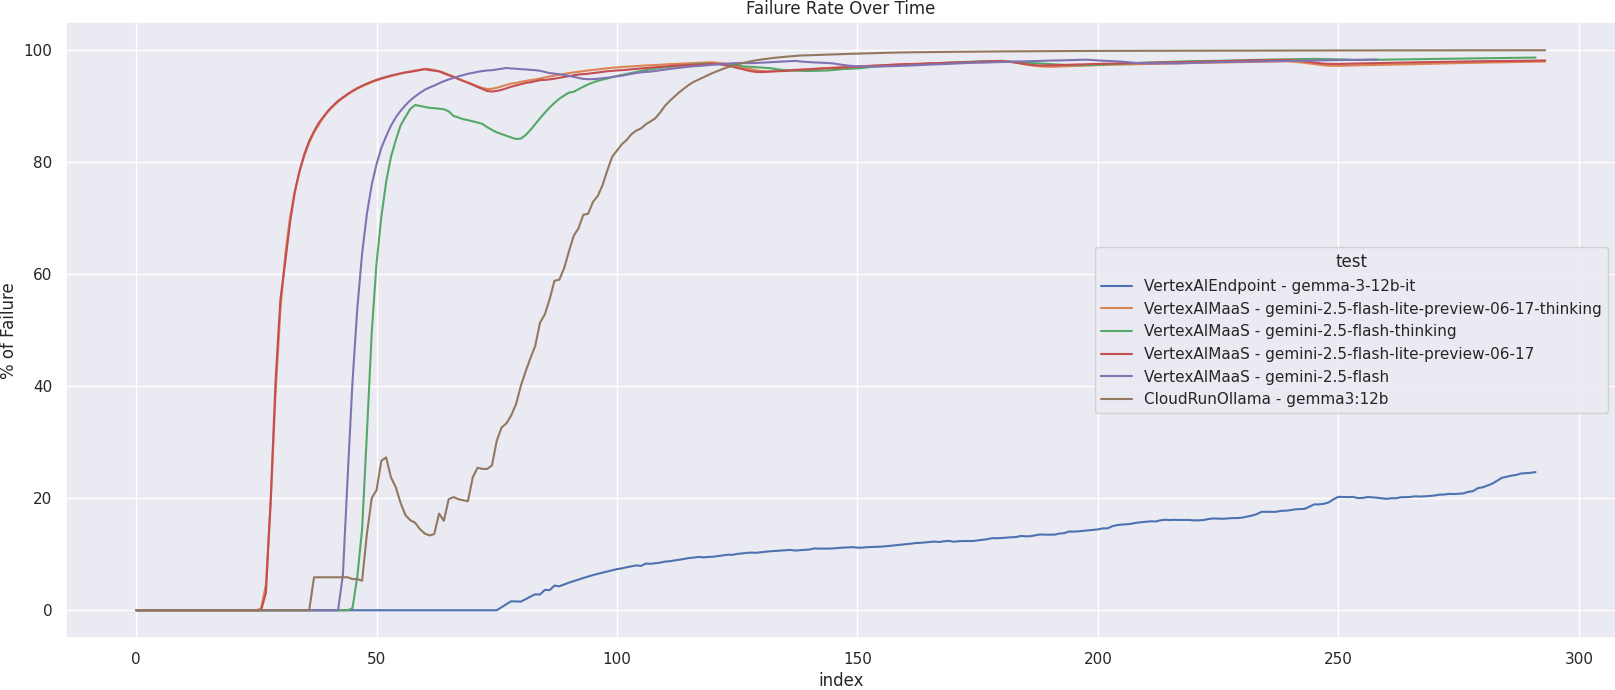

In [10]:
ax= sns.lineplot(
    data=history,
    x="index",
    hue="test",
    y="% of Failure",
)
ax.set_title("Failure Rate Over Time")
ax.figure.savefig(FIGURES_PATH / "failure_rate_over_time.png")

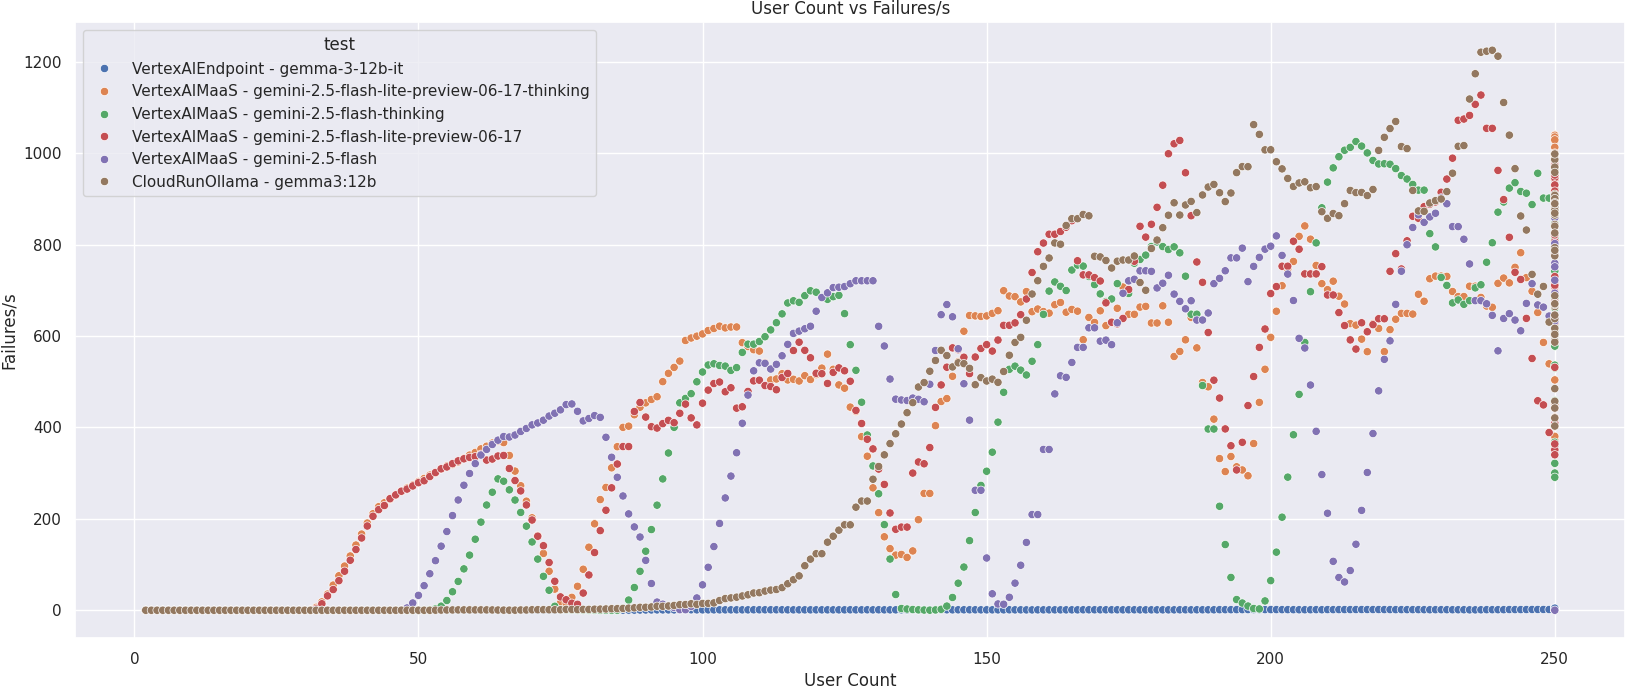

In [11]:
ax = sns.scatterplot(
    data=history,
    x="User Count",
    y="Failures/s",
    hue="test",
)
ax.set_title("User Count vs Failures/s")
ax.figure.savefig(FIGURES_PATH / "user_count_vs_failures.png")

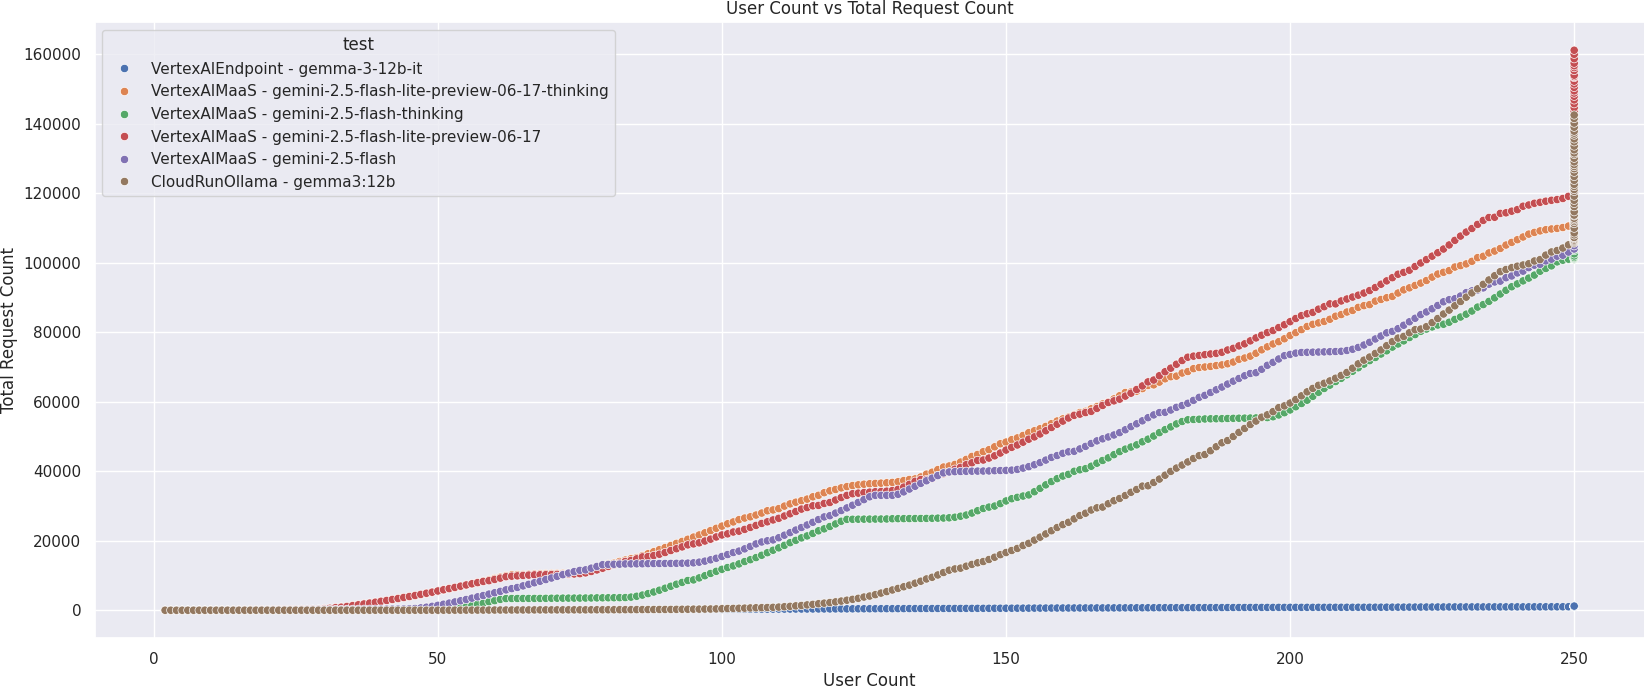

In [ ]:
ax = sns.scatterplot(
    data=history,
    x="User Count",
    y="Total Request Count",
    hue="test",
)
ax.set_title("User Count vs Total Request Count")
ax.figure.savefig(FIGURES_PATH / "user_count_vs_total_request_count.png")

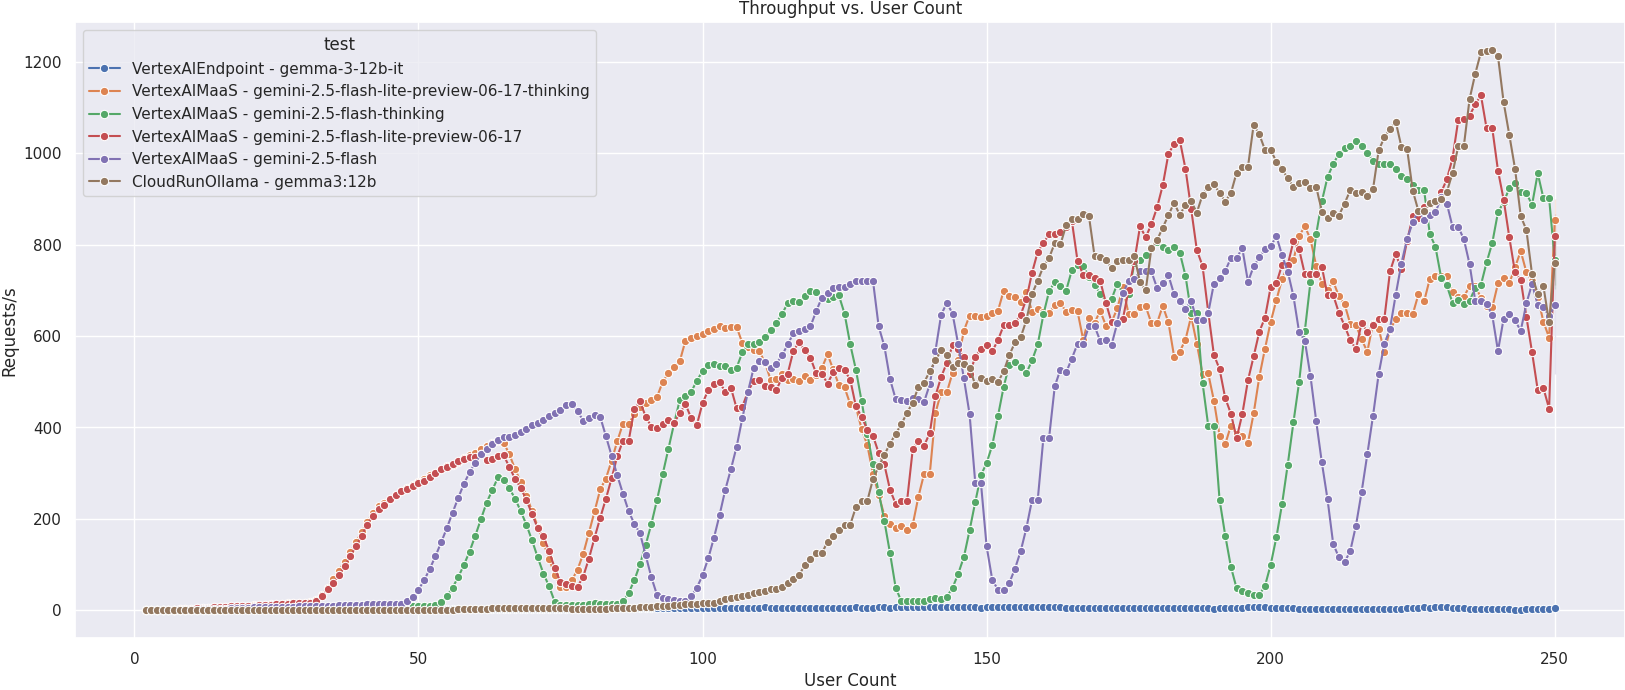

In [ ]:
ax = sns.lineplot(
    data=history,
    x="User Count",
    y="Requests/s",
    hue="test",
    marker="o",
)
ax.set_title("Throughput vs. User Count")
ax.figure.savefig(FIGURES_PATH / "throughput_vs_user_count.png")